Importamos las librerias necesarias

In [71]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

Descargo el archivo comprimido de la web, se que no he escogido el mejor conjunto de reviews ya que las tarjetas de felicitación no tienen mucho margen de opinión y es un grupo pequeño de datos pero he tenido problemas para descomprimir otros con más datos por el limite de ram de colab, con lo que con más tiempo y memoria ram el análisis habría sido más interesante.

In [72]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Gift_Cards.json.gz

--2023-09-02 06:40:53--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Gift_Cards.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11333918 (11M) [application/x-gzip]
Saving to: ‘Gift_Cards.json.gz.2’

Gift_Cards.json.gz. 100%[===================>]  10.81M  21.6MB/s    in 0.5s    

2023-09-02 06:40:53 (21.6 MB/s) - ‘Gift_Cards.json.gz.2’ saved [11333918/11333918]



In [73]:
### Lo descomprimo y cargo los datos

data = []
with gzip.open('Gift_Cards.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# Extraigo el total de elementos del data
print(len(data))

# Y muestro la primera línea del dataset
print(data[0])

147194
{'overall': 1.0, 'vote': '25', 'verified': False, 'reviewTime': '12 19, 2008', 'reviewerID': 'APV13CM0919JD', 'asin': 'B001GXRQW0', 'style': {'Gift Amount:': ' 50'}, 'reviewerName': 'LEH', 'reviewText': 'Amazon,\nI am shopping for Amazon.com gift cards for Christmas gifts and am really so disappointed that out of five choices there isn\'t one that says "Merry Christmas" or mentions Christmas at all!  I am sure I am not alone in wanting a card that reflects the actual "holiday" we are celebrating. On principle, I cannot send a Amazon gift card this Christmas.  What\'s up with all the Political Correctness?  Bad marketing decision.\nLynn', 'summary': 'Merry Christmas.', 'unixReviewTime': 1229644800}


In [74]:
# Transformo la lista de elementos en un dataframe de pandas

df = pd.DataFrame.from_dict(data)

print(len(df))

147194


Voy a generar un dataframe filtrado donde limito los elementos con el mismo número de estrellas, es un truquillo para tener un conjunto de datos balanceado, ya que los datos de este conjuento estan muy desbalanceados y no conseguiriamos entrenar bien el modelo, siendo consciente de que los resultados no se ajustarán a la realidad. Esto me ha limitado a que los conjuntos de valoraciones por número de estrellas no pueda ser superior a 1000. Con más tiempo habría aplicado otras técnicas de balanceado y normalización menos básicas (Oversampling, Undersamplimg, ...).

In [75]:
with gzip.open('Gift_Cards.json.gz', 'rb') as f:
  df = pd.read_json(f, lines=True)

filtered_df = df[df['overall'].isin([1, 2, 3, 4, 5])]


num_samples = 1000
sampled_df_1 = filtered_df[filtered_df['overall'] == 1].sample(n=num_samples)
sampled_df_2 = filtered_df[filtered_df['overall'] == 2].sample(n=num_samples)
sampled_df_3 = filtered_df[filtered_df['overall'] == 3].sample(n=num_samples)
sampled_df_4 = filtered_df[filtered_df['overall'] == 4].sample(n=num_samples)
sampled_df_5 = filtered_df[filtered_df['overall'] == 5].sample(n=num_samples)


result_df = pd.concat([sampled_df_1, sampled_df_2, sampled_df_3, sampled_df_4, sampled_df_5]).reset_index(drop = True)

result_df.to_csv('data_file.csv', index=False)

Compruebo como queda el dataframe

In [76]:
print(result_df.head())

   overall vote  verified   reviewTime      reviewerID        asin  \
0        1    2      True  02 10, 2017  A2CRWP2FB4TKMT  B00BXLTMRC   
1        1  NaN      True   06 6, 2014  A17NCZFPT37WSH  B00BWDHVC4   
2        1  NaN      True  05 30, 2016  A2BPII513TLOH3  B00P9VHCBU   
3        1  NaN      True  01 12, 2018  A2QVRF04UGWZGJ  B01E4QPDV6   
4        1    3      True  12 28, 2017  A1BBUPYYRCGE3S  B01E4QUN0W   

                     style      reviewerName  \
0                      NaN  Joanne B. Martin   
1                      NaN      tr maushardt   
2                      NaN   Amazon Customer   
3   {'Gift Amount:': ' 0'}    Marian Shirley   
4  {'Gift Amount:': ' 25'}          Danielle   

                                          reviewText  \
0  bought as Xmas present for my collage girl. Th...   
1  Although I used the gift card for other events...   
2                       It came Within a couple min.   
3  Card won't be accepted when trying to use it f...   
4  Amazon 

Hago una pequeña limpieza de columnas que no aportan información

In [77]:
# Lista de nombres de columnas que voy a eliminar
columnas_a_eliminar = ['vote', 'style', 'asin', 'unixReviewTime', 'image']

# Con drop() para elimino las columnas en ambos df
result_df = result_df.drop(columns=columnas_a_eliminar)
df = df.drop(columns=columnas_a_eliminar)

# Imprimo el DataFrame resultante para verificar
print(result_df.head())

   overall  verified   reviewTime      reviewerID      reviewerName  \
0        1      True  02 10, 2017  A2CRWP2FB4TKMT  Joanne B. Martin   
1        1      True   06 6, 2014  A17NCZFPT37WSH      tr maushardt   
2        1      True  05 30, 2016  A2BPII513TLOH3   Amazon Customer   
3        1      True  01 12, 2018  A2QVRF04UGWZGJ    Marian Shirley   
4        1      True  12 28, 2017  A1BBUPYYRCGE3S          Danielle   

                                          reviewText  \
0  bought as Xmas present for my collage girl. Th...   
1  Although I used the gift card for other events...   
2                       It came Within a couple min.   
3  Card won't be accepted when trying to use it f...   
4  Amazon kept screwing with my codes and I lost ...   

                                             summary  
0                                      disappointing  
1   THIS CARD EXPIRED BEFORE RECIPIENT COULD USE IT!  
2                                           One Star  
3               

Cardinalidad del Vocabulario con y sin StopWords, para sacar las palabras del corpus, ver su frecuencia y reflejarlas en un plot. Lo hago con y sin stopwords para ver si en este caso es últil su aplicación

In [78]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Cargo un conjunto de stopwords en ingles
stop_words = set(stopwords.words('english'))

# Creo una lista para almacenar todas las palabras del texto
all_words = []


# Recorro cada fila del DataFrame y tokenizo el texto
for index, row in result_df.iterrows():
    if isinstance(row['reviewText'], str):  # Verifico si es una cadena, ya que me ha dado problemas porque no todo son cadenas de texto
        words = nltk.word_tokenize(row['reviewText'])
        words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
        all_words.extend(words)


# Calculo la frecuencia de las palabras
word_freq = Counter(all_words)

# Muestro las palabras más comunes y sus frecuencias
print(word_freq.most_common())



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('gift', 4038), ('card', 3614), ('amazon', 1236), ('cards', 956), ('would', 761), ('use', 680), ('get', 616), ('one', 609), ('time', 511), ('great', 504), ('could', 478), ('sent', 449), ('like', 429), ('received', 420), ('easy', 416), ('buy', 408), ('good', 385), ('purchase', 368), ('box', 366), ('got', 354), ('recipient', 346), ('way', 328), ('birthday', 318), ('email', 316), ('order', 312), ('give', 310), ('never', 309), ('know', 299), ('used', 285), ('work', 285), ('christmas', 278), ('day', 264), ('send', 260), ('bought', 251), ('ordered', 249), ('nice', 243), ('message', 235), ('able', 235), ('print', 229), ('service', 229), ('go', 227), ('arrived', 225), ('even', 224), ('really', 219), ('someone', 214), ('love', 214), ('account', 211), ('purchased', 199), ('money', 192), ('still', 192), ('delivered', 191), ('came', 190), ('disappointed', 186), ('store', 184), ('another', 182), ('problem', 179), ('said', 178), ('customer', 178), ('back', 176), ('idea', 173), ('sure', 171), ('prod

In [79]:

# Creo una lista para almacenar todas las palabras del texto pero en este caso sin quitar las stopwords
all_words_w = []

# Recorro cada fila del DataFrame y tokenizo el texto
for index, row in result_df.iterrows():
    if isinstance(row['reviewText'], str):  # Verifico si es una cadena
        words_w = nltk.word_tokenize(row['reviewText'])
        words_w = [word.lower() for word in words_w if word.isalpha() and word.lower()]
        all_words_w.extend(words_w)

# Calculo la frecuencia de las palabras
word_freq_w = Counter(all_words_w)

# Muestro las palabras más comunes y sus frecuencias
print(word_freq_w.most_common())

[('the', 7391), ('to', 5828), ('i', 5640), ('it', 4814), ('a', 4423), ('gift', 4038), ('card', 3614), ('and', 3552), ('was', 3272), ('for', 2314), ('not', 1961), ('this', 1925), ('my', 1706), ('of', 1633), ('that', 1571), ('in', 1537), ('is', 1478), ('on', 1399), ('amazon', 1236), ('but', 1234), ('you', 1162), ('have', 1110), ('with', 1085), ('as', 987), ('they', 986), ('be', 957), ('had', 957), ('cards', 956), ('so', 870), ('did', 863), ('would', 761), ('do', 696), ('use', 680), ('me', 648), ('from', 644), ('no', 629), ('get', 616), ('one', 609), ('very', 596), ('when', 570), ('if', 565), ('an', 564), ('out', 537), ('time', 511), ('great', 504), ('what', 497), ('or', 496), ('can', 483), ('she', 482), ('just', 482), ('could', 478), ('at', 474), ('there', 469), ('are', 451), ('sent', 449), ('them', 442), ('like', 429), ('will', 426), ('received', 420), ('easy', 416), ('buy', 408), ('good', 385), ('who', 374), ('all', 374), ('purchase', 368), ('box', 366), ('got', 354), ('only', 348), ('

aqui ya voy viendo que las stopwords meten mucho ruido

In [80]:
all_words[:15]

['bought',
 'xmas',
 'present',
 'collage',
 'girl',
 'einsteins',
 'shop',
 'campus',
 'cant',
 'use',
 'would',
 'except',
 'disappointed',
 'although',
 'used']

In [81]:
all_words_w[:15]

['bought',
 'as',
 'xmas',
 'present',
 'for',
 'my',
 'collage',
 'girl',
 'they',
 'have',
 'einsteins',
 'shop',
 'on',
 'campus',
 'she']

Importo la librería para poder dibujar el plot

In [82]:
import matplotlib.pyplot as plt

Hago el conteo

In [83]:
wf = Counter(all_words)
wf_w = Counter(all_words_w)

Agrupo en una variable las más comunes sin y con stopwords

In [84]:
wf_most_common = wf.most_common(15)
wf_most_common



[('gift', 4038),
 ('card', 3614),
 ('amazon', 1236),
 ('cards', 956),
 ('would', 761),
 ('use', 680),
 ('get', 616),
 ('one', 609),
 ('time', 511),
 ('great', 504),
 ('could', 478),
 ('sent', 449),
 ('like', 429),
 ('received', 420),
 ('easy', 416)]

In [85]:
wf_most_common_w = wf_w.most_common(15)
wf_most_common_w

[('the', 7391),
 ('to', 5828),
 ('i', 5640),
 ('it', 4814),
 ('a', 4423),
 ('gift', 4038),
 ('card', 3614),
 ('and', 3552),
 ('was', 3272),
 ('for', 2314),
 ('not', 1961),
 ('this', 1925),
 ('my', 1706),
 ('of', 1633),
 ('that', 1571)]

Preparo las etiquetas para los ejes

In [86]:
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]

words_w = [w[0] for w in wf_most_common_w]
freqs_w = [w[1] for w in wf_most_common_w]

In [87]:
freqs, words = zip(*sorted(zip(freqs, words)))

freqs_w, words_w = zip(*sorted(zip(freqs_w, words_w)))

Y dibujo, quitando las StopWords

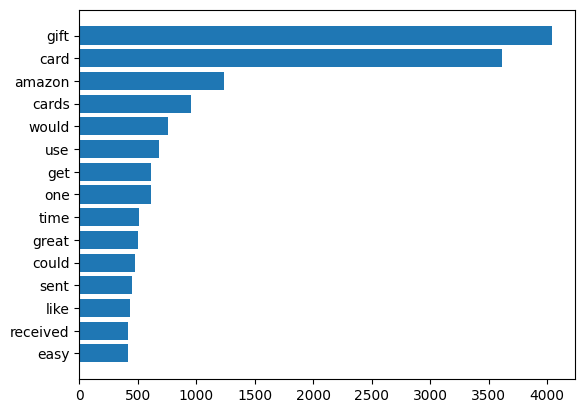

In [88]:
plt.barh(words, freqs)
plt.show()

Y sin quitar StopWords

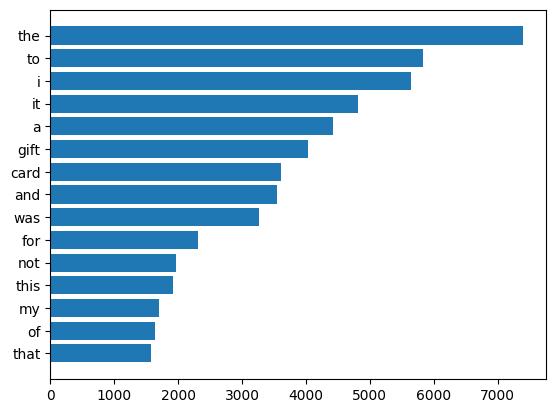

In [89]:
plt.barh(words_w, freqs_w)
plt.show()

Vemos claramente que es necesario el excluir las stopwords

Voy a generara una "Nube de Texto" para ver de forma visual las palabras más significativas

In [90]:
from wordcloud import WordCloud

In [91]:
def plot_word_cloud(words):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(all_words))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

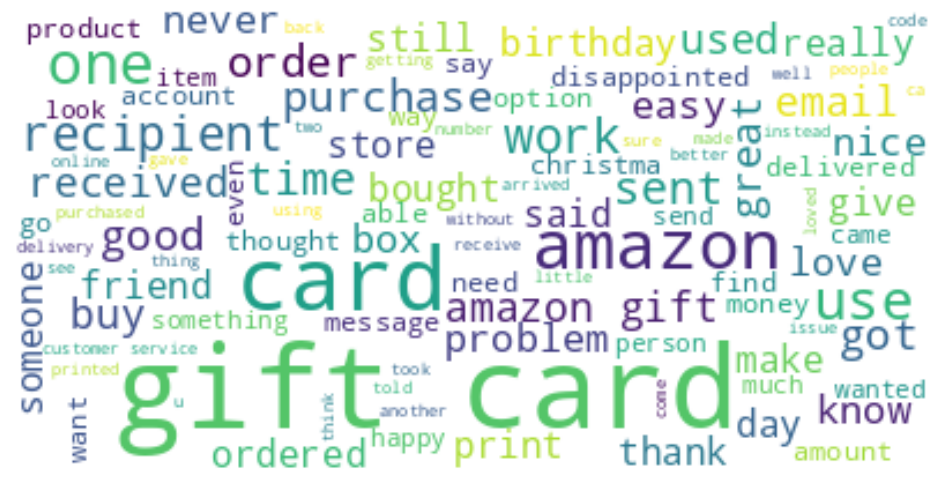

In [92]:
words_list = all_words
plot_word_cloud(words_list)

Voy a realizar la distribución de reviews por número de estrellas, voy a usar el df original y el filtrado ("balanceado"), para comprobar la necesidad del balanceo de los datos.

Sin balancear

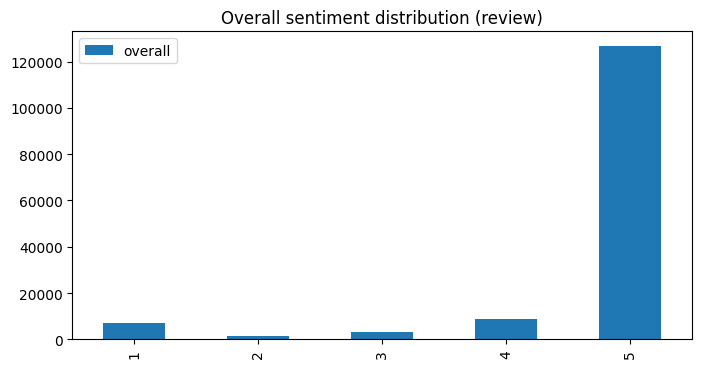

In [93]:
aux_df = pd.DataFrame(df['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

Balanceado

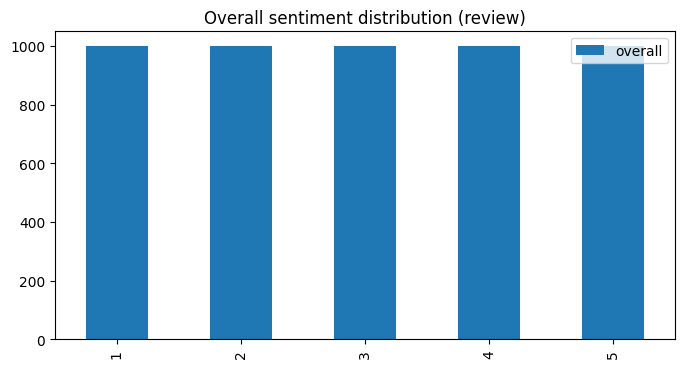

In [94]:
aux_df = pd.DataFrame(result_df['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

Preparo una distribución binaria

In [95]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 1
    else:
        return 0

In [96]:
#def categorize_sentiment(rating):
 #   if rating in [1, 2]:
  #      return '1-2 Estrellas'
   # elif rating in [3, 4]:
    #    return '3-4 Estrellas'
    #elif rating == 5:
    #    return '5 Estrellas'
    #else:
    #    return 'No Clasificado'

In [97]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [98]:
df.head()

,overall,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,sentiment_label
0,1,False,"12 19, 2008",APV13CM0919JD,LEH,"Amazon,\nI am shopping for Amazon.com gift car...",Merry Christmas.,1
1,5,False,"12 17, 2008",A3G8U1G1V082SN,Tali,"I got this gift card from a friend, and it was...",Gift card with best selection,0
2,5,False,"12 17, 2008",A11T2Q0EVTUWP,Z,aren't we going to save trees?! :) People who ...,A convenient and great gift for the environmen...,0
3,5,False,"12 17, 2008",A9YKGBH3SV22C,Giotravels,You can always get someone something from Amaz...,Totally make sense,0
4,1,True,"12 17, 2008",A34WZIHVF3OKOL,King Dad,Why take 50 dollars of good money with no limi...,Give CASH!,1


In [99]:
result_df['sentiment_label'] = result_df.apply(lambda row: label_sentiment(row), axis=1)

In [100]:
result_df.head()

,overall,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,sentiment_label
0,1,True,"02 10, 2017",A2CRWP2FB4TKMT,Joanne B. Martin,bought as Xmas present for my collage girl. Th...,disappointing,1
1,1,True,"06 6, 2014",A17NCZFPT37WSH,tr maushardt,Although I used the gift card for other events...,THIS CARD EXPIRED BEFORE RECIPIENT COULD USE IT!,1
2,1,True,"05 30, 2016",A2BPII513TLOH3,Amazon Customer,It came Within a couple min.,One Star,1
3,1,True,"01 12, 2018",A2QVRF04UGWZGJ,Marian Shirley,Card won't be accepted when trying to use it f...,What can we do?,1
4,1,True,"12 28, 2017",A1BBUPYYRCGE3S,Danielle,Amazon kept screwing with my codes and I lost ...,Amazon screwed up. Just give cash. This isn't ...,1


Sin balancear

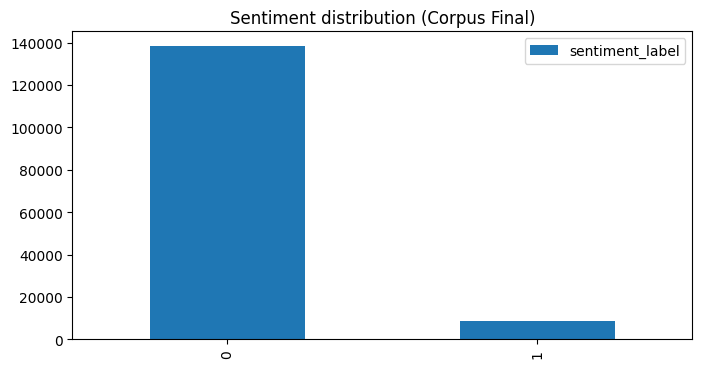

In [101]:
aux_df = pd.DataFrame(df['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

Balanceado

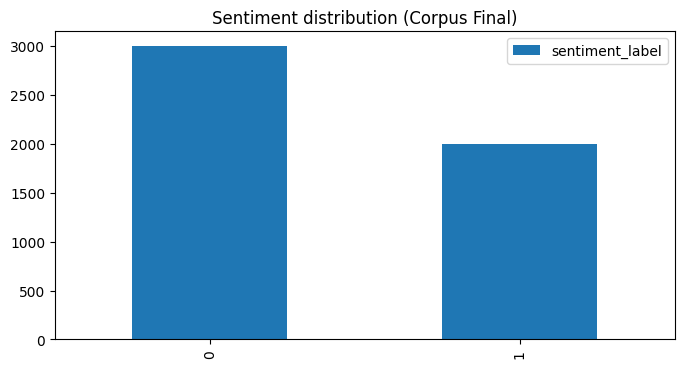

In [102]:
result_df['sentiment_label'] = result_df.apply(lambda row: label_sentiment(row), axis=1)
aux_df = pd.DataFrame(result_df['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

Conclusiones

Veo que las palabras más comunes son regalo, tarjeta, envío, embalaje, ... que están relacionadas con la naturaleza del producto. Como ya comenté comprueblo que es útil quitar las stopwords ya que generan ruido y no aportan información, y por último queda muy clara la importancia del balanceado en los datos con este tipo de productos.

Exporto los df en csv para poder seguir usandolo en otros cuadernos

In [103]:
df.to_csv('data_final1.csv', index=False)

In [104]:
result_df.to_csv('data_final2.csv', index=False)